In [1]:
import pandas as pd

### Data Collection

In [ ]:
import requests

# URLs of the files
data_url = 'https://www.raphaelcousin.com/modules/module5/course/module5_course_handling_missing_values.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(train_data, 'module5_course_handling_missing_values.csv')

In [2]:
df = pd.read_csv("module5_course_handling_missing_values.csv", sep=",", index_col=0)

## Data Analysis

DataFrame head:
                           RotorRPM  ReactivePower  GeneratorRPM  WindSpeed  \
2019-05-06 14:10:00+00:00  0.672715     -15.007223     68.210284   2.212693   
2019-05-06 14:30:00+00:00  0.508198     -10.851533     68.229411   2.130019   
2019-05-06 14:50:00+00:00  0.715614     -10.303578     85.012009   2.347810   
2019-05-06 15:00:00+00:00  0.550434     -12.594477     63.945036   2.161460   
2019-05-06 15:10:00+00:00  0.251628     -11.181515     21.339981   1.913490   

                           Blade1PitchAngle  AmbientTemperatue  ActivePower  
2019-05-06 14:10:00+00:00         45.736893          39.308243    -7.851491  
2019-05-06 14:30:00+00:00         41.260297          39.206277    -5.565284  
2019-05-06 14:50:00+00:00         39.576077          39.194184    -5.549332  
2019-05-06 15:00:00+00:00         47.399521          38.992667    -5.768376  
2019-05-06 15:10:00+00:00               NaN          38.686212    -5.091456  

DataFrame info:
<class 'pandas.core.fram

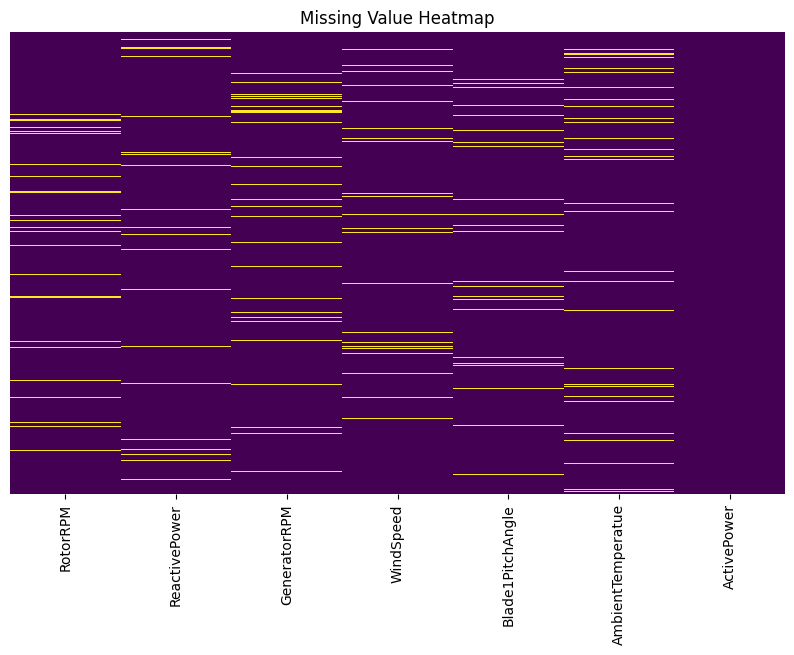

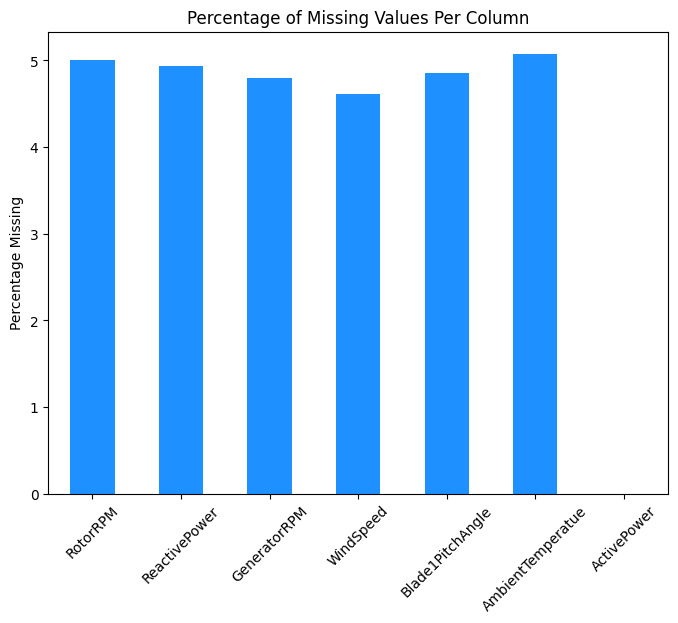

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame loaded with the data shown above
# df = pd.read_csv('your_file.csv', index_col=0, parse_dates=True)

# Print the first few rows of the DataFrame to understand its structure
print("DataFrame head:")
print(df.head())

# Basic info about the dataset
print("\nDataFrame info:")
df.info()

# Summarize missing values per column
print("\nMissing values per column:")
missing_data = df.isnull().sum()
print(missing_data)

# Percentage of missing values per column
print("\nPercentage of missing values per column:")
percent_missing = df.isnull().mean() * 100
print(percent_missing)

# Visualizing missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Value Heatmap')
plt.show()

# Visualizing percentage of missing values
plt.figure(figsize=(8, 6))
percent_missing.plot(kind='bar', color='dodgerblue')
plt.title('Percentage of Missing Values Per Column')
plt.ylabel('Percentage Missing')
plt.xticks(rotation=45)
plt.show()


## Data Cleaning - Handling Missing Values

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge

# Function to evaluate data cleaning methods
def eval_cleaning_data(model, X_train_clean, X_test_clean, y_train, y_test):
    model.fit(X_train_clean, y_train)
    y_pred = model.predict(X_test_clean)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"MSE: {mse}, MAE: {mae}")

# Function to split data into train and test sets
def split_data(X, y, train_ratio=0.8):
    n = int(train_ratio * len(X))
    return X.iloc[:n], X.iloc[n:], y.iloc[:n], y.iloc[n:]

# Data Preprocessing: Impute training data and transform test data with the same imputation model
def impute_data(imputer, X_train, X_test, add_column_is_missing=False):
    if add_column_is_missing:
        for column in X_train.columns:
            X_train[column + '_is_missing'] = X_train[column].isnull()
            X_test[column + '_is_missing'] = X_test[column].isnull()
    
    # Apply the imputation to the training data
    # fit_transform: Fits the imputation model to the training data and transforms it.
    # This learns the necessary statistics (e.g., mean, median) from the training data used to impute missing values
    # and then applies this imputation strategy directly to the training data.
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    
    # Apply the learned imputation to the test data
    # transform: Applies the imputation strategy learned from the training data to the test data.
    # This ensures that the test data is treated as new, unseen data and prevents any data leakage,
    # meaning no information from the test set influences the training process.
    # It only uses the statistics (e.g., mean, median) calculated from the training data for imputations.
    X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

    return X_train_imputed, X_test_imputed

# Assuming df is predefined
X = df.drop('ActivePower', axis=1)
y = df['ActivePower']
X_train, X_test, y_train, y_test = split_data(X, y)

model = LinearRegression(n_jobs=-1)

# Different imputation strategies
imputers = {
    "Zero fill": SimpleImputer(strategy='constant', fill_value=0),
    "Mean fill": SimpleImputer(strategy='mean'),
    "KNN Imputation": KNNImputer(n_neighbors=5),
    "Iterative Imputation (Bayesian Ridge)": IterativeImputer(estimator=BayesianRidge(), random_state=0)
}

# Evaluate each imputation strategy with and without adding is_missing columns
for name, imputer in imputers.items():
    print(f"Evaluating {name} without is_missing:")
    X_train_imputed, X_test_imputed = impute_data(imputer, X_train.copy(), X_test.copy(), add_column_is_missing=False)
    eval_cleaning_data(model, X_train_imputed, X_test_imputed, y_train, y_test)

    print(f"Evaluating {name} with is_missing:")
    X_train_imputed_with_missing, X_test_imputed_with_missing = impute_data(imputer, X_train.copy(), X_test.copy(), add_column_is_missing=True)
    eval_cleaning_data(model, X_train_imputed_with_missing, X_test_imputed_with_missing, y_train, y_test)


Evaluating Zero fill without is_missing:
MSE: 50956.72345153454, MAE: 119.88356802288757
Evaluating Zero fill with is_missing:
MSE: 42823.2768519814, MAE: 96.29684405558362
Evaluating Mean fill without is_missing:
MSE: 42961.478333298764, MAE: 96.4212572572216
Evaluating Mean fill with is_missing:
MSE: 42823.27685198205, MAE: 96.29684405558243
Evaluating KNN Imputation without is_missing:
MSE: 57025.57147417511, MAE: 66.78531466395954
Evaluating KNN Imputation with is_missing:
MSE: 57216.30576803896, MAE: 65.82013692041892
Evaluating Iterative Imputation (Bayesian Ridge) without is_missing:


/home/raphael/admin_data_science_practice/venv/lib/python3.10/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


MSE: 58838.67688604158, MAE: 69.75146218588367
Evaluating Iterative Imputation (Bayesian Ridge) with is_missing:
MSE: 58827.471080188305, MAE: 69.79455410199616


/home/raphael/admin_data_science_practice/venv/lib/python3.10/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
